In [105]:
#Import deps 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight



# ... 

### Introduction
What makes the perfect bottle of wine? 

Wine is a major industry, with sales projected to steadily grow beyond $40 billion USD by 2029. [Source](https://www.statista.com/statistics/922403/global-wine-market-size/)

For the longest time, the secrets of the timeless art of winemaking were restricted to the intuitions and implicit knowledge of the vintners themselves. Today it is possible to apply the techniques of machine learning to analyze the chemical components of wine to determine how they influence the quality rating of the wine.

This study conducts machine learning analysis on the chemical constitutents of 6497 different wines (1599 reds and 4898 white ) to identify the predictive relationships between these features and wine quality. 

The purpose of this study is to show how machine learning can be applied to commercial pursuits and potentially improve sales and production quality of products. 


In [106]:
# Import Data 
all_wine_raw_df = pd.read_csv('./Wine_data_both.csv') 
red_wine_df = pd.read_csv('./Wine_data_red.csv')
white_wine_df = pd.read_csv('./Wine_data_white.csv')


In [107]:
# Inspect raw data 
print('All wine data types', all_wine_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  Wine                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
All wine data types None


### Data Preparation, Encoding & Feature Engineering

In [188]:
all_9s = all_wine_raw_df.drop(columns='Wine')[all_wine_raw_df['quality'] == 9]
all_3s = all_wine_raw_df.drop(columns=['Wine'])[all_wine_raw_df['quality'] == 3]
all_4s = all_wine_raw_df.drop(columns=['Wine'])[all_wine_raw_df['quality'] == 4]

mean_all_9s = all_9s.mean()
mean_all_3s = all_3s.mean()
mean_all_4s = all_4s.mean()
# Compare the means (difference between highest and lowest rated wines)
mean_difference = mean_all_9s - mean_all_3s

# Display the results
print("Mean values for highest rated wines (quality == 9):")
print(mean_all_9s)
print("\nMean values for lowest rated wines (quality == 3):")
print(mean_all_3s)
print("\nDifference in mean values:")
print(mean_difference)


Mean values for highest rated wines (quality == 9):
fixed acidity             7.42000
volatile acidity          0.29800
citric acid               0.38600
residual sugar            4.12000
chlorides                 0.02740
free sulfur dioxide      33.40000
total sulfur dioxide    116.00000
density                   0.99146
pH                        3.30800
sulphates                 0.46600
alcohol                  12.18000
quality                   9.00000
wine_category             2.00000
dtype: float64

Mean values for lowest rated wines (quality == 3):
fixed acidity             7.853333
volatile acidity          0.517000
citric acid               0.281000
residual sugar            5.140000
chlorides                 0.077033
free sulfur dioxide      39.216667
total sulfur dioxide    122.033333
density                   0.995744
pH                        3.257667
sulphates                 0.506333
alcohol                  10.215000
quality                   3.000000
wine_category      

In [189]:
# Note: May need to workshop this/ run it by the TAs
def generate_synthetic_samples(mean_values, n_samples, noise_level=0.01):
    synthetic_samples = []
    for _ in range(n_samples):
        noise = np.random.normal(0, noise_level, mean_values.shape)
        synthetic_sample = mean_values + noise
        synthetic_samples.append(synthetic_sample)
    return pd.DataFrame(synthetic_samples, columns=mean_values.index)

n_samples_to_generate = 50  # Number of synthetic samples to generate for each class
synthetic_9s = generate_synthetic_samples(mean_all_9s, n_samples_to_generate)
synthetic_3s = generate_synthetic_samples(mean_all_3s, n_samples_to_generate)
synetic_4s = generate_synthetic_samples(mean_all_3s, n_samples_to_generate)
# Add the target column to the synthetic samples
synthetic_9s['quality'] = 9
synthetic_3s['quality'] = 3

# Combine synthetic samples with the original data
synthetic_data = pd.concat([synthetic_9s, synthetic_3s])
combined_data = pd.concat([all_wine_raw_df, synthetic_data])

In [182]:

# Wines are to be classified as "low", "medium", or "high"
# def assign_category(quality):
#     if quality <=5:
#         return 'low'
#     elif quality == 6:
#         return 'medium'
#     elif quality >6:
#         return 'high'

# Manually encode the wine type, 0 is White, Red is 1
# all_wine_raw_df['wine type'] = all_wine_raw_df['wine type'].map({'White': 0, 'Red': 1})

# Apply the assign_category function 
# all_wine_raw_df['wine_category'] = all_wine_raw_df['quality'].apply(lambda quality: assign_category(quality))
# Manually encode the wine category
# all_wine_raw_df['wine_category'] = all_wine_raw_df['wine_category'].map({'low': 0, 'medium': 1, 'high': 2})
# Define the feature and target variables
X = combined_data.drop(columns=['quality', 'Wine'], axis=1)
y = combined_data['quality']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

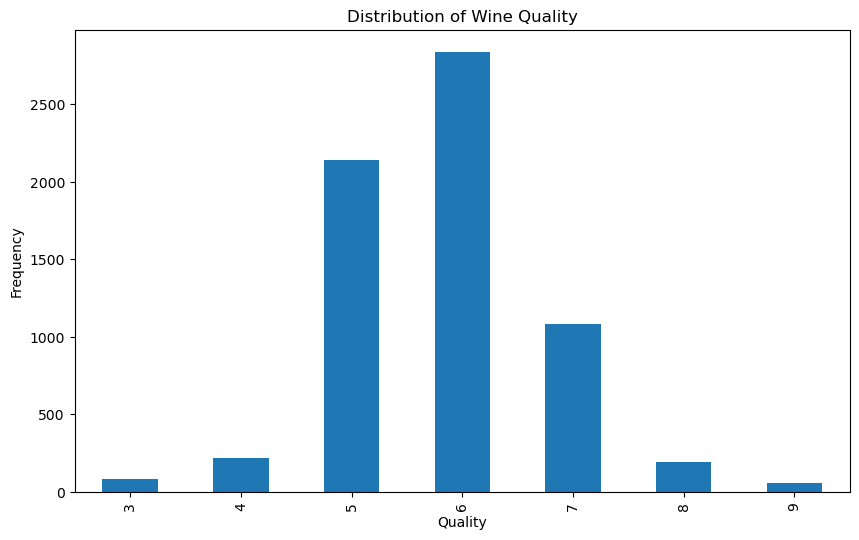

In [190]:
# Determine if data is balanced or imbalanced
plt.figure(figsize=(10, 6))
y.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')
plt.show()

# Clustering or feature engineering by clumping 3s/4s/5s/ low  6s/ medium/ 7,8,9 high quality 

In [70]:
# # # Feature Selection: What features can we drop? 


Class distribution before resampling:
 quality
6    2269
5    1710
7     863
4     173
8     154
3      64
9      44
Name: count, dtype: int64
Class distribution after resampling:
 quality
3    2269
5    2269
6    2269
7    2269
9    2269
8    2269
4    2269
Name: count, dtype: int64


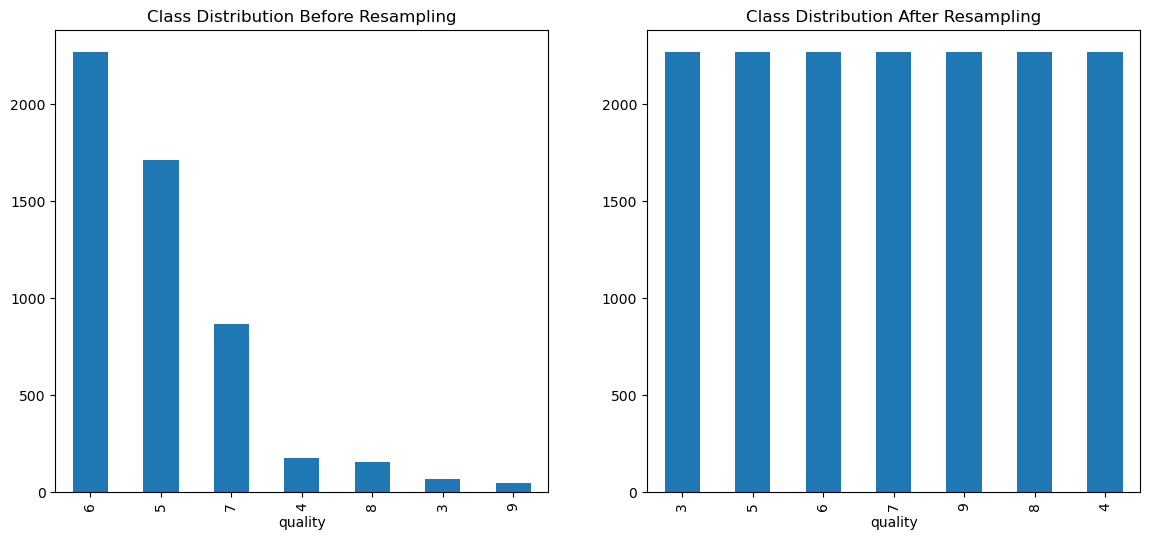

       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   15883.000000      15883.000000  15883.000000    15883.000000   
mean        7.265837          0.368723      0.305983        4.939029   
std         1.062835          0.207609      0.185916        3.719074   
min         3.800000         -0.230465     -0.275089        0.600000   
25%         6.600000          0.234445      0.220000        2.100000   
50%         7.223244          0.310003      0.302573        4.100848   
75%         7.724356          0.462108      0.396839        5.761793   
max        15.900000          1.580000      1.660000       31.600000   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  15883.000000         15883.000000          15883.000000  15883.000000   
mean       0.060296            31.333264            114.278712      0.992748   
std        0.121411            18.639017             50.958276      0.125876   
min       -0.858441            

In [191]:
class_distribution_before = y_train.value_counts()
print("Class distribution before resampling:\n", class_distribution_before)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Class distribution after resampling
class_distribution_after = y_train_resampled.value_counts()
print("Class distribution after resampling:\n", class_distribution_after)

# Plot the class distributions before and after resampling
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
class_distribution_before.plot(kind='bar', ax=axes[0], title='Class Distribution Before Resampling')
class_distribution_after.plot(kind='bar', ax=axes[1], title='Class Distribution After Resampling')
plt.show()
# Since our data is imbalanced, we may want to correct it by oversampling the minority classes 
print(X_train_resampled.describe())


### Scaling the Data


In [185]:

scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the testing data (use the same scaler fitted on the training data)
X_test_scaled = scaler.transform(X_test)

In [125]:
print(y_test.value_counts())

quality
6    567
5    428
7    216
4     43
8     39
3      6
9      1
Name: count, dtype: int64


### Build Models

In [153]:
# Define a simpler parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
}
# Since our data is very imbalanced, lets try calculating class weights 
unique_classes = np.array([3, 4, 5, 6, 7, 8, 9])
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(unique_classes, class_weights)}

print(f'Class weights: {class_weight_dict}')


Class weights: {3: 7.358516483516484, 4: 4.423616845582163, 5: 0.4475355054302423, 6: 0.3372788516023421, 7: 0.8867737129614303, 8: 4.969387755102041, 9: 9.110544217687075}


In [192]:
# Initialize RFC
rfc = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_distributions,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

# Perform the random search on the resampled and scaled training data
random_search.fit(X_train, y_train)

# Get the best model
best_rfc = random_search.best_estimator_

# Predict on the scaled test data
y_pred_rfc = best_rfc.predict(X_test)

# Evaluate the best model
print("Best Gradient Boosting Classifier Classification Report:")
print(classification_report(y_test, y_pred_rfc))
print("Best Gradient Boosting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfc))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END criterion=log_loss, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END criterion=log_loss, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END criterion=log_loss, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20

In [194]:
print(best_rfc)
classifier = RandomForestClassifier( class_weight=class_weight_dict, criterion='log_loss', max_depth=10, max_features='log2', n_estimators=200, random_state=42)
classifier.fit(X=X_train, y=y_train)
y_pred_best = classifier.predict(X_test)

print("Best RFC Classification Report:")
print(classification_report(y_test, y_pred_best))
print("Best RFC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

RandomForestClassifier(class_weight={3: 7.358516483516484, 4: 4.423616845582163,
                                     5: 0.4475355054302423,
                                     6: 0.3372788516023421,
                                     7: 0.8867737129614303,
                                     8: 4.969387755102041,
                                     9: 9.110544217687075},
                       max_depth=5, n_estimators=300, random_state=42)
Best RFC Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.56      0.72        16
           4       0.41      0.28      0.33        43
           5       0.92      0.96      0.94       428
           6       1.00      1.00      1.00       567
           7       0.89      0.99      0.93       216
           8       0.83      0.38      0.53        39
           9       1.00      0.73      0.84        11

    accuracy                           0.94      1320
   macro avg       0.86      

With Scaling - RMSE: 1.0133891612838817, R^2: -0.4367073899417533


### Evaluation & Interpretation 